# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

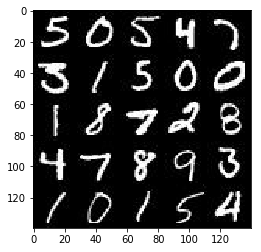

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

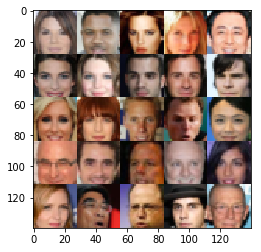

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_dim
        
        out = tf.tanh(logits)
        
    return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          print_every=10, show_every=100, n_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Normalize real images to value range -1 ... 1
                batch_images = batch_images*2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0578... Generator Loss: 16.1418
Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 6.0928
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 6.6234
Epoch 1/2... Discriminator Loss: 0.5038... Generator Loss: 2.9448
Epoch 1/2... Discriminator Loss: 0.4519... Generator Loss: 2.9388
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 3.0782
Epoch 1/2... Discriminator Loss: 0.5749... Generator Loss: 2.3105
Epoch 1/2... Discriminator Loss: 0.4992... Generator Loss: 2.6926
Epoch 1/2... Discriminator Loss: 1.3430... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 0.8744... Generator Loss: 2.3939


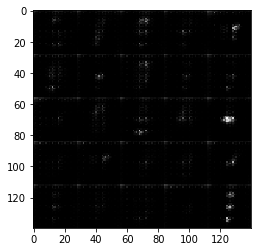

Epoch 1/2... Discriminator Loss: 0.8275... Generator Loss: 1.3275
Epoch 1/2... Discriminator Loss: 1.7830... Generator Loss: 5.1083
Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 3.9781
Epoch 1/2... Discriminator Loss: 0.9822... Generator Loss: 1.3190
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 1.7399
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 2.3212
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.1291... Generator Loss: 1.8488
Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.4822
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 2.5701


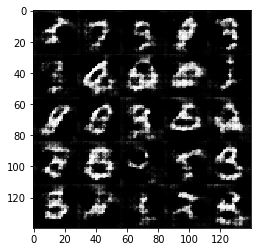

Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 2.2384
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.1682... Generator Loss: 1.0445
Epoch 1/2... Discriminator Loss: 2.1523... Generator Loss: 3.6609
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 1.1115
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.1723


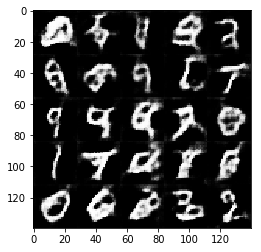

Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 0.3955
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 1.7801
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.5348
Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 0.4153
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 1.8656
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 1.4861


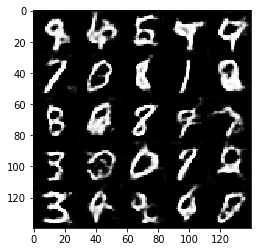

Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.6384
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.5585
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.5259
Epoch 1/2... Discriminator Loss: 1.4249... Generator Loss: 1.9043
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 1.7700
Epoch 2/2... Discriminator Loss: 1.4679... Generator Loss: 0.4940
Epoch 2/2... Discriminator Loss: 1.1494... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 1.0540


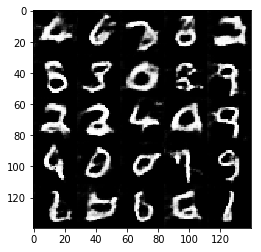

Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 1.1361... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 1.2175... Generator Loss: 0.8359
Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 1.4168
Epoch 2/2... Discriminator Loss: 1.1137... Generator Loss: 1.2775
Epoch 2/2... Discriminator Loss: 1.1581... Generator Loss: 1.1698
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 1.7683
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 0.5786


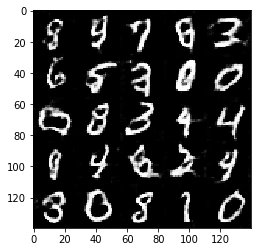

Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 1.6630
Epoch 2/2... Discriminator Loss: 1.2469... Generator Loss: 1.6438
Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 1.6346
Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 1.0348
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 1.5309... Generator Loss: 0.4620
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 1.0717


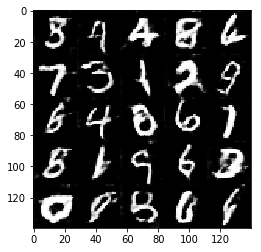

Epoch 2/2... Discriminator Loss: 1.8341... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5341
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.0813
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.5657... Generator Loss: 0.4614
Epoch 2/2... Discriminator Loss: 1.7584... Generator Loss: 0.4012
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5503
Epoch 2/2... Discriminator Loss: 1.4408... Generator Loss: 0.5228


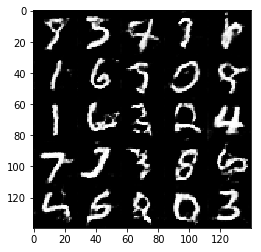

Epoch 2/2... Discriminator Loss: 1.7453... Generator Loss: 0.3455
Epoch 2/2... Discriminator Loss: 1.2326... Generator Loss: 0.9434
Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.4513
Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.6660
Epoch 2/2... Discriminator Loss: 1.3217... Generator Loss: 1.5060
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 1.6291
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.8688
Epoch 2/2... Discriminator Loss: 1.3956... Generator Loss: 0.5592


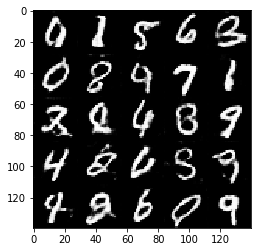

Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.5847... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.8018


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 7.7505
Epoch 1/1... Discriminator Loss: 0.7037... Generator Loss: 1.7344
Epoch 1/1... Discriminator Loss: 2.0074... Generator Loss: 6.5849
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.3804
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.6987
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 2.4323
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.2844


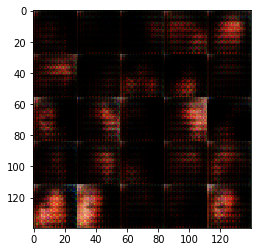

Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 2.0668... Generator Loss: 3.3179
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.3242


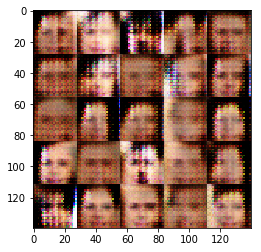

Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.2524
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.4268


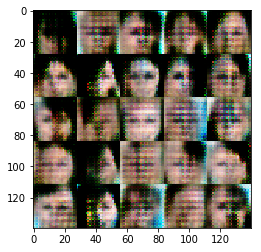

Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.5188
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.6529... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.2531
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 2.3105


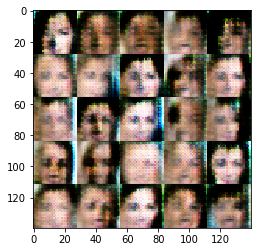

Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 2.0686... Generator Loss: 0.2460
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.5127
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 1.7622
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.2440


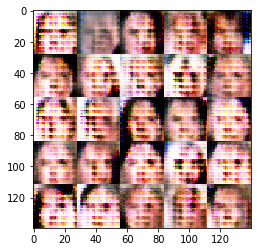

Epoch 1/1... Discriminator Loss: 2.0717... Generator Loss: 2.8400
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.5149
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.7460
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 2.1114... Generator Loss: 2.2153
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.8483


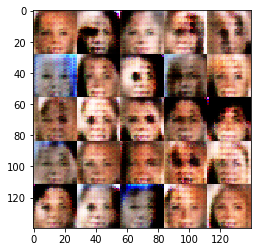

Epoch 1/1... Discriminator Loss: 1.7423... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.4495
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 1.0784


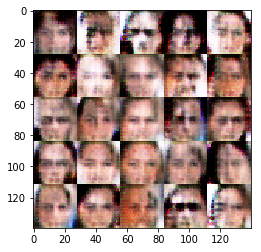

Epoch 1/1... Discriminator Loss: 1.7054... Generator Loss: 3.2796
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 2.0814
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.6178
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.7855
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.2292


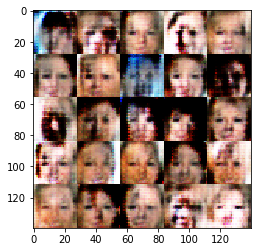

Epoch 1/1... Discriminator Loss: 3.5444... Generator Loss: 3.5721
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.4627
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.1318


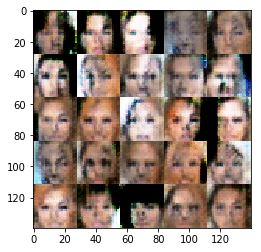

Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 3.2043... Generator Loss: 3.5451
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.2868
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.5670
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.0167


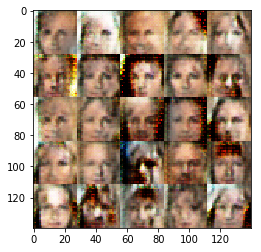

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.5962... Generator Loss: 2.0398
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 1.8509
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 0.8799... Generator Loss: 1.1551
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 1.5991


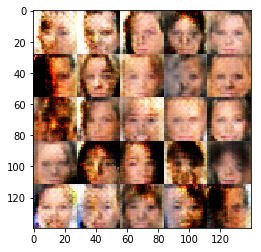

Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.1837
Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 3.7562... Generator Loss: 6.5869
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.2063


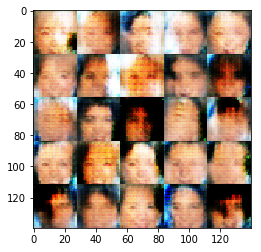

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.7643
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.7978
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 2.3509
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.8810... Generator Loss: 0.2954


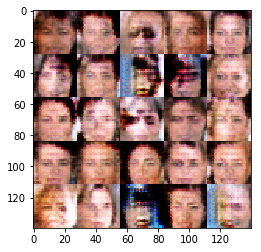

Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 2.2575... Generator Loss: 2.6461
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 2.1046
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 1.4658


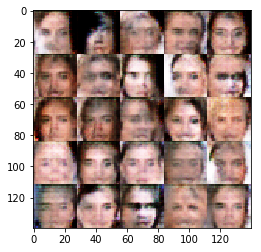

Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.7974
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 2.1572
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.3929
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.6846
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.9667


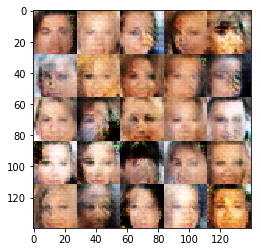

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.5304... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.1649
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.7632


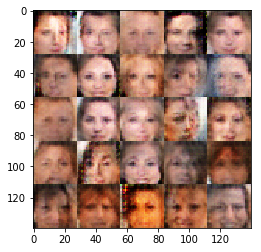

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 2.1983
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 1.1392


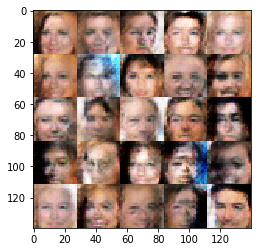

Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.8662


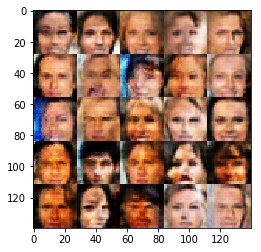

Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.8111


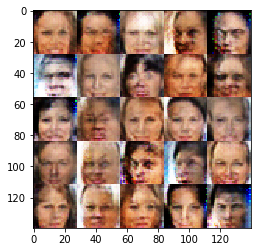

Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 1.4877
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.2402
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.9794


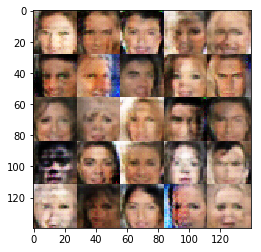

Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 2.1700
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5018


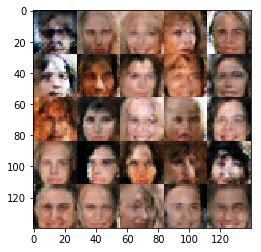

Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.1212


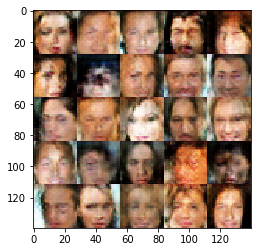

Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.0718... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.2088


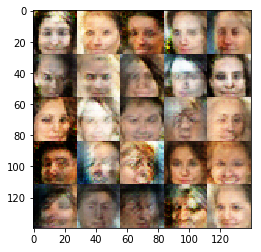

Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9954


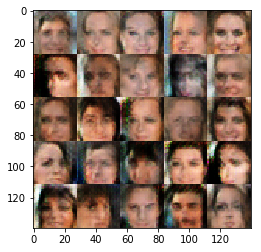

Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8067


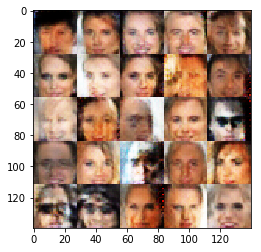

Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3884
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.2714


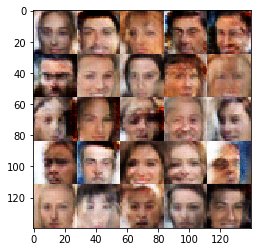

Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 1.0874


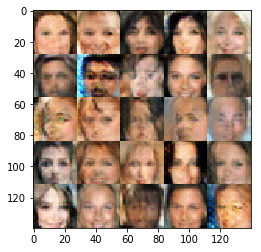

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 2.2470... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.4673
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.9179


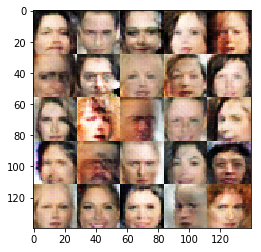

Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.7697


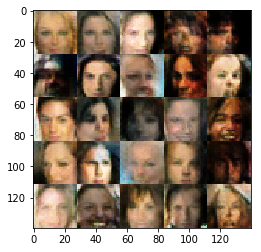

Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8564


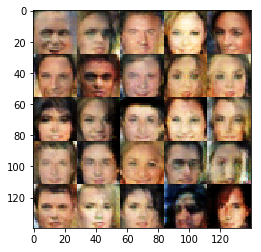

Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.9353
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7105


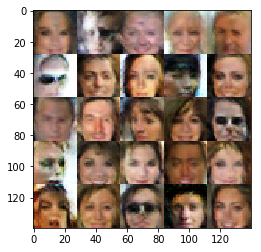

Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.7566


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.